✓ torch_tensorrt imported successfully.
Using device: cuda
✓ Found model file for 'TensorRT FP32'
✓ Found model file for 'TensorRT FP16'
🚀 Starting TensorRT Model Comparison

                LOADING TENSORRT MODELS
  -> Loading resnet50_trt_fp32.ts to cuda...
✓ Successfully loaded TensorRT FP32
  -> Loading resnet50_trt_fp16.ts to cuda...
✓ Successfully loaded TensorRT FP16

✅ Successfully loaded 2 models for benchmarking.

==================== RUNNING BENCHMARK WITH INPUT SHAPE: (32, 3, 224, 224) ====================
Benchmarking TensorRT FP32...
Benchmarking TensorRT FP16...
  -> Input tensor converted to FP16.

📊 Creating visualizations...


/tmp/ipykernel_2600/2542122780.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df, x='Model', y='Inference Time (ms)', ax=axes[0, 0], palette='coolwarm'); ax1.set_title('Average Inference Time (Latency)')
/tmp/ipykernel_2600/2542122780.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df, x='Model', y='Throughput (FPS)', ax=axes[0, 1], palette='viridis'); ax2.set_title('Throughput (Frames Per Second)')
/tmp/ipykernel_2600/2542122780.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(data=df, x='Model'

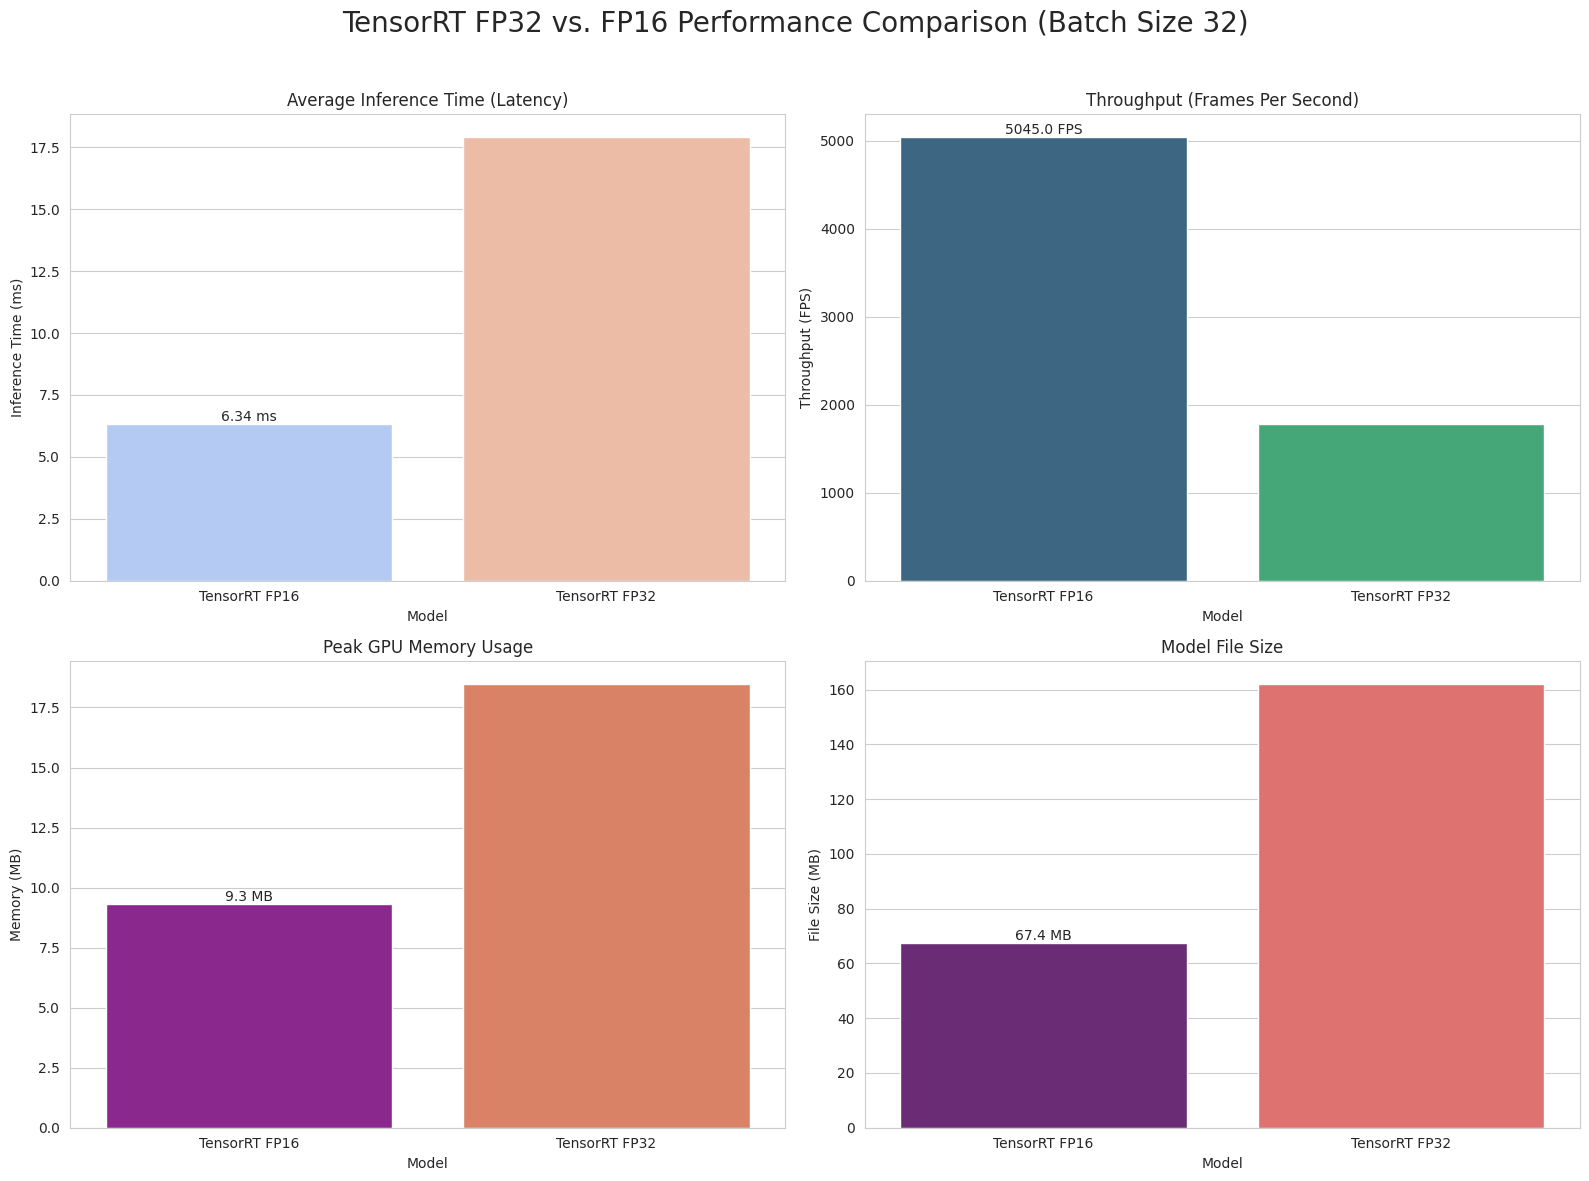


📋 OPTIMIZATION SUMMARY TABLE (Batch Size 32)
           Model  Latency (ms)  Throughput (FPS)  Size (MB)  GPU Mem (MB)  Speedup vs FP32  Compression vs FP32
0  TensorRT FP16          6.34           5044.97      67.38          9.31             2.83                 2.41
1  TensorRT FP32         17.94           1784.12     162.20         18.50             1.00                 1.00

🎉 Analysis complete!


In [2]:
# %%
# ===================================================================
#                      IMPORTS AND SETUP
# ===================================================================
import torch
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import gc

try:
    import torch_tensorrt
    print("✓ torch_tensorrt imported successfully.")
except ImportError:
    print("✗ FATAL: torch_tensorrt is not installed. This script cannot run without it.")
    exit()

if not torch.cuda.is_available():
    print("✗ FATAL: CUDA is not available. TensorRT requires a GPU.")
    exit()
DEVICE = torch.device("cuda")
print(f"Using device: {DEVICE}")

sns.set_style("whitegrid")


# %%
# ===================================================================
#                           MODEL PATHS
# ===================================================================
# --- Correct path for running inside a Docker container ---
CONTAINER_DATA_PATH = '/workspace'

MODEL_PATHS = {
    'TensorRT FP32': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/tensorrt/resnet50_trt_fp32.ts'),
    'TensorRT FP16': os.path.join(CONTAINER_DATA_PATH, r'saved_models_and_logs/tensorrt/resnet50_trt_fp16.ts')
}

for name, path in MODEL_PATHS.items():
    if not os.path.exists(path):
        print(f"⚠️ WARNING: Path for '{name}' not found: {path}")
    else:
        print(f"✓ Found model file for '{name}'")


# %%
# ===================================================================
#                     BENCHMARKING CONFIGURATION
# ===================================================================
# --- [THE FIX] ---
# Setting the input shape to match the exact shape used during compilation.
# Your compilation script used (32, 3, 224, 224).
DUMMY_INPUT_SHAPE = (32, 3, 224, 224)


# %%
# ===================================================================
#                         MODEL LOADER CLASS
# ===================================================================
class ModelLoader:
    @staticmethod
    def load_jit_model(path):
        print(f"  -> Loading {os.path.basename(path)} to {DEVICE}...")
        model = torch.jit.load(path, map_location=DEVICE)
        return model.eval()


# %%
# ===================================================================
#                      BENCHMARKING UTILITIES
# ===================================================================
def get_file_size_mb(file_path):
    if os.path.exists(file_path): return os.path.getsize(file_path) / (1024 * 1024)
    return 0
def warm_up_model(model, input_tensor, num_warmup=20):
    with torch.no_grad():
        for _ in range(num_warmup): _ = model(input_tensor)
        torch.cuda.synchronize()
def benchmark_model(model, input_tensor_cpu, num_runs=100, model_name="Model"):
    print(f"Benchmarking {model_name}...")
    input_tensor = input_tensor_cpu.to(DEVICE)
    model.to(DEVICE)
    if 'FP16' in model_name:
        input_tensor = input_tensor.half()
        print("  -> Input tensor converted to FP16.")
    warm_up_model(model, input_tensor)
    torch.cuda.reset_peak_memory_stats(DEVICE)
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_event = torch.cuda.Event(enable_timing=True); end_event = torch.cuda.Event(enable_timing=True)
            start_event.record(); _ = model(input_tensor); end_event.record()
            torch.cuda.synchronize(DEVICE); times.append(start_event.elapsed_time(end_event))
    mem_used = torch.cuda.max_memory_allocated(DEVICE) / 1024**2
    times = np.array(times)
    stats = {'mean': np.mean(times), 'std': np.std(times), 'median': np.median(times), 'throughput_fps': 1000 / np.mean(times) * input_tensor.shape[0], 'memory_mb': mem_used}
    return stats, times


# %%
# ===================================================================
#                        MODEL LOADING LOGIC
# ===================================================================
def load_tensorrt_models():
    models_dict = OrderedDict(); model_info = OrderedDict()
    print("\n" + "="*50); print("                LOADING TENSORRT MODELS"); print("="*50)
    for display_name, path in MODEL_PATHS.items():
        try:
            models_dict[display_name] = ModelLoader.load_jit_model(path)
            model_info[display_name] = {'type': 'TensorRT', 'precision': 'FP16' if 'FP16' in display_name else 'FP32', 'file_size_mb': get_file_size_mb(path)}
            print(f"✓ Successfully loaded {display_name}")
        except Exception as e:
            print(f"✗ Failed to load {display_name} from {path}. Error: {e}")
    return models_dict, model_info


# %%
# ===================================================================
#                   COMPREHENSIVE BENCHMARK RUNNER
# ===================================================================
def run_comprehensive_benchmark(models_dict, model_info):
    all_results = {}; all_times = {}
    batch_size, C, H, W = DUMMY_INPUT_SHAPE
    print(f"\n{'='*20} RUNNING BENCHMARK WITH INPUT SHAPE: {(batch_size, C, H, W)} {'='*20}")
    test_input_cpu = torch.randn(batch_size, C, H, W)
    batch_results = OrderedDict(); batch_times = OrderedDict()
    for model_name, model in models_dict.items():
        try:
            stats, times = benchmark_model(model, test_input_cpu, num_runs=100, model_name=model_name)
            if stats is not None:
                stats.update(model_info[model_name]); stats['batch_size'] = batch_size
                batch_results[model_name] = stats; batch_times[model_name] = times
        except Exception as e:
            print(f"\nERROR: Benchmarking for {model_name} failed unexpectedly.")
            print(f"   Input shape used: {test_input_cpu.shape}")
            print(f"   Input dtype: {test_input_cpu.dtype}")
            print(f"   Error details: {e}")

        torch.cuda.empty_cache(); gc.collect()
    all_results[batch_size] = batch_results; all_times[batch_size] = batch_times
    return all_results, all_times


# %%
# ===================================================================
#                       PLOTTING & REPORTING
# ===================================================================
def create_comparison_plots(all_results):
    plot_data = []; batch_size = DUMMY_INPUT_SHAPE[0]
    for _, results in all_results.items():
        if not results: continue
        for model_name, stats in results.items():
            plot_data.append({'Model': model_name, 'Inference Time (ms)': stats['mean'], 'Throughput (FPS)': stats['throughput_fps'], 'Memory (MB)': stats['memory_mb'], 'File Size (MB)': stats['file_size_mb']})
    df = pd.DataFrame(plot_data)
    if df.empty: print("No data to plot."); return None
    df = df.sort_values('Model').reset_index(drop=True)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12)); fig.suptitle(f'TensorRT FP32 vs. FP16 Performance Comparison (Batch Size {batch_size})', fontsize=20)
    ax1 = sns.barplot(data=df, x='Model', y='Inference Time (ms)', ax=axes[0, 0], palette='coolwarm'); ax1.set_title('Average Inference Time (Latency)')
    if not df.empty: ax1.bar_label(ax1.containers[0], fmt='%.2f ms')
    ax2 = sns.barplot(data=df, x='Model', y='Throughput (FPS)', ax=axes[0, 1], palette='viridis'); ax2.set_title('Throughput (Frames Per Second)')
    if not df.empty: ax2.bar_label(ax2.containers[0], fmt='%.1f FPS')
    ax3 = sns.barplot(data=df, x='Model', y='Memory (MB)', ax=axes[1, 0], palette='plasma'); ax3.set_title('Peak GPU Memory Usage')
    if not df.empty: ax3.bar_label(ax3.containers[0], fmt='%.1f MB')
    ax4 = sns.barplot(data=df, x='Model', y='File Size (MB)', ax=axes[1, 1], palette='magma'); ax4.set_title('Model File Size')
    if not df.empty: ax4.bar_label(ax4.containers[0], fmt='%.1f MB')
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()
    return df
def create_summary_table(df):
    if df is None or df.empty: return None
    summary_data = df.copy()
    try:
        fp32_stats = summary_data[summary_data['Model'] == 'TensorRT FP32'].iloc[0]
        summary_data['Speedup'] = fp32_stats['Inference Time (ms)'] / summary_data['Inference Time (ms)']
        summary_data['Size Reduction'] = fp32_stats['File Size (MB)'] / summary_data['File Size (MB)']
    except (IndexError, KeyError):
        summary_data['Speedup'] = 1.0; summary_data['Size Reduction'] = 1.0
    display_columns = {'Model': 'Model', 'Inference Time (ms)': 'Latency (ms)', 'Throughput (FPS)': 'Throughput (FPS)', 'File Size (MB)': 'Size (MB)', 'Memory (MB)': 'GPU Mem (MB)', 'Speedup': 'Speedup vs FP32', 'Size Reduction': 'Compression vs FP32'}
    summary_table = summary_data[list(display_columns.keys())].copy(); summary_table = summary_table.rename(columns=display_columns)
    for col in summary_table.columns:
        if np.issubdtype(summary_table[col].dtype, np.number): summary_table[col] = summary_table[col].round(2)
    summary_table = summary_table.sort_values('Speedup vs FP32', ascending=False).reset_index(drop=True)
    print("\n" + "="*120); print(f"📋 OPTIMIZATION SUMMARY TABLE (Batch Size {DUMMY_INPUT_SHAPE[0]})"); print("="*120); print(summary_table.to_string())
    return summary_table


# %%
# ===================================================================
#                           MAIN EXECUTION
# ===================================================================
if __name__ == "__main__":
    print("🚀 Starting TensorRT Model Comparison")
    models_dict, model_info = load_tensorrt_models()

    if not models_dict:
        print("\n❌ No models were loaded.")
    else:
        print(f"\n✅ Successfully loaded {len(models_dict)} models for benchmarking.")
        all_results, _ = run_comprehensive_benchmark(models_dict, model_info)
        print("\n📊 Creating visualizations...")
        df_results = create_comparison_plots(all_results)
        summary_table = create_summary_table(df_results)
        print("\n🎉 Analysis complete!")